## Relevant Libraries

In [76]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime


## Connect to Postgre

In [23]:
load_dotenv()

# PostgreSQL Configuration
db_params = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "sslmode": os.getenv("DB_SSLMODE")
}

conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

# Get list of tables in public schema
cursor.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public'
""")
tables = cursor.fetchall()

# Dictionary to hold DataFrames
table_data = {}

for (table_name,) in tables:
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    table_data[table_name] = df

cursor.close()
conn.close()


C:\Users\GIDI\AppData\Local\Temp\ipykernel_4252\705200099.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


## Drivers Table

In [24]:
drivers= table_data['drivers']
drivers.head()

,driver_id,rating,vehicle_type,signup_date,last_active,city,acceptance_rate
0,D00000,3.1,SUV,2025-01-20,2025-01-06 18:23:09,Cairo,0.679555
1,D00001,5.0,Sedan,2023-03-27,2025-04-27 01:44:02,Nairobi,0.548786
2,D00002,4.5,Motorcycle,2024-05-02,2025-03-07 19:24:46,Nairobi,0.593724
3,D00003,5.0,Motorcycle,2023-04-16,2025-03-26 19:16:24,Nairobi,0.990000
4,D00004,4.4,Motorcycle,2023-05-28,2025-04-08 18:54:45,Lagos,0.519773


## Inspection and Data Cleaning

In [25]:
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driver_id        5000 non-null   object 
 1   rating           5000 non-null   float64
 2   vehicle_type     5000 non-null   object 
 3   signup_date      5000 non-null   object 
 4   last_active      5000 non-null   object 
 5   city             5000 non-null   object 
 6   acceptance_rate  5000 non-null   float64
dtypes: float64(2), object(5)
memory usage: 273.6+ KB


No missing values. The dataset has 5000 rows and 7 columns.

In [26]:
# Check unique elements in each column and print them out
for column in drivers.columns:
    unique_values = drivers[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'driver_id':
['D00000' 'D00001' 'D00002' ... 'D04997' 'D04998' 'D04999']

Unique values in 'rating':
[3.1 5.  4.5 4.4 3.7 4.6 3.3 4.1 3.8 4.9 3.4 4.7 4.2 4.8 3.5 3.6 4.3 4.
 3.9 3.2]

Unique values in 'vehicle_type':
['SUV' 'Sedan' 'Motorcycle' 'Luxury']

Unique values in 'signup_date':
['2025-01-20' '2023-03-27' '2024-05-02' ... '2025-01-08' '2022-11-14'
 '2023-04-01']

Unique values in 'last_active':
['2025-01-06 18:23:09' '2025-04-27 01:44:02' '2025-03-07 19:24:46' ...
 '2025-04-16 08:52:21' '2025-04-06 03:43:05' '2025-02-09 05:47:23']

Unique values in 'city':
['Cairo' 'Nairobi' 'Lagos']

Unique values in 'acceptance_rate':
[0.67955484 0.5487857  0.59372375 ... 0.82724354 0.5201239  0.68538236]



categorical=['vehicle_type','city']

In [27]:
# Convert object columns to 'category' type
category_columns = ['vehicle_type', 'city']
for col in category_columns:
    drivers[col] = drivers[col].astype('category')

# Convert date columns to datetime
date_columns = ['signup_date', 'last_active']
for col in date_columns:
    drivers[col] = pd.to_datetime(drivers[col])

# Check the updated data types
drivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   driver_id        5000 non-null   object        
 1   rating           5000 non-null   float64       
 2   vehicle_type     5000 non-null   category      
 3   signup_date      5000 non-null   datetime64[ns]
 4   last_active      5000 non-null   datetime64[ns]
 5   city             5000 non-null   category      
 6   acceptance_rate  5000 non-null   float64       
dtypes: category(2), datetime64[ns](2), float64(2), object(1)
memory usage: 205.5+ KB


In [28]:
# Checking for duplicates
drivers.duplicated().sum()

0

In [29]:
drivers.describe()

,rating,signup_date,last_active,acceptance_rate
count,5000.000000,5000,5000,5000.000000
mean,4.172440,2023-10-24 01:58:22.080000,2025-03-07 13:50:29.265600,0.695318
min,3.100000,2022-04-27 00:00:00,2022-04-28 16:45:24,0.100000
25%,3.700000,2023-01-18 18:00:00,2025-03-13 08:03:29.750000128,0.565169
50%,4.200000,2023-10-20 00:00:00,2025-04-08 11:24:16.500000,0.697731
75%,4.700000,2024-07-28 00:00:00,2025-04-19 19:19:43,0.837700
max,5.000000,2025-04-26 00:00:00,2025-04-27 16:20:56,0.990000
std,0.594073,NaN,NaN,0.186216


### Driver Performance & Engagement Analysis

This analysis explores key metrics from a ride-hailing driver dataset with 5,000 entries. The focus is on driver ratings, signup activity, recent engagement, and acceptance behavior.

---

### 1. Driver Ratings

- **Mean rating:** 4.17  
- **Min rating:** 3.1  
- **Max rating:** 5.0  
- **Standard Deviation:** 0.59  
- **75th percentile:** 4.7

**Insight:**  
Most drivers are rated highly, with 75% having a rating of 4.7 or lower. The distribution is skewed toward higher ratings, indicating overall good performance. However, some outliers on the lower end (as low as 3.1) may need performance reviews or customer feedback follow-ups.

---

### 2. Signup Date Distribution

- **Earliest signup:** April 27, 2022  
- **Latest signup:** April 26, 2025  
- **Median signup date:** October 20, 2023

**Insight:**  
Drivers have been joining the platform steadily over the past three years. The median indicates most drivers joined in late 2023, showing recent growth in onboarding efforts.

---

### 3. Last Active Date

- **Earliest last active:** April 28, 2022  
- **Latest last active:** April 27, 2025  
- **Median last active date:** April 8, 2025

**Insight:**  
The majority of drivers are still active or were active recently. The platform appears to have a healthy retention rate with a strong proportion of active drivers as of 2025.

---

### 4. Acceptance Rate

- **Mean acceptance rate:** 69.5%  
- **Min:** 10%  
- **Max:** 99%  
- **Median:** 69.8%

**Insight:**  
Most drivers have moderate to high acceptance rates, reflecting general responsiveness to ride requests. However, a few drivers have very low acceptance rates, which could indicate part-time engagement or selective behavior.

---

###  Summary

- The platform is expanding with new drivers.
- Ratings and engagement metrics show strong performance.
- Some drivers may require performance coaching or deeper review based on low ratings or low acceptance behavior.



## Distribution

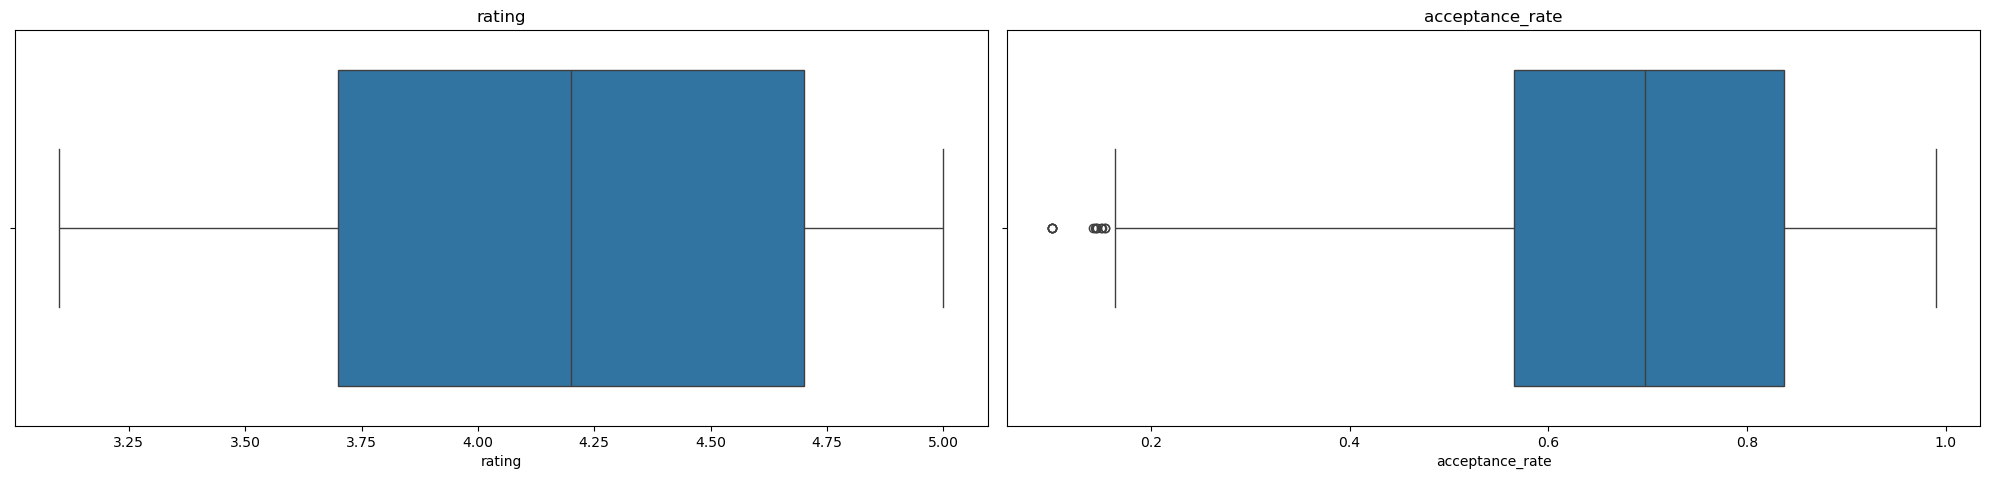

In [30]:
#Get names of all numerical feature
num_vars=drivers.select_dtypes(include=['int','float']).columns.tolist()

# Create a figure with subplots

num_cols=len(num_vars)
num_rows = num_cols
fig,axes=plt.subplots(nrows=num_cols,ncols=2,figsize=(20,4.5*num_rows))
axes=axes.flatten()

# Create a countplot for the top 6  values 
for i, var in enumerate(num_vars):
    sns.boxplot(x=drivers[var],ax=axes[i])
    axes[i].set_title(var)
    
# Remove any extra empty subplots if needed
if num_cols < len(axes):
    for i in range(num_cols,len(axes)):
        fig.delaxes(axes[i])
        
# Adjust spacing  between subplots
fig.tight_layout()


## Exploratory Data Analysis

In [31]:
# Create a copy for analysis
df_analysis = drivers.copy()

In [32]:
# New features
df_analysis["days_active"] = (df_analysis["last_active"] - df_analysis["signup_date"]).dt.days
df_analysis["year_signed_up"] = df_analysis["signup_date"].dt.year
df_analysis["month_signed_up"] = df_analysis["signup_date"].dt.month

### Which vehicle type has the highest driver acceptance rate?

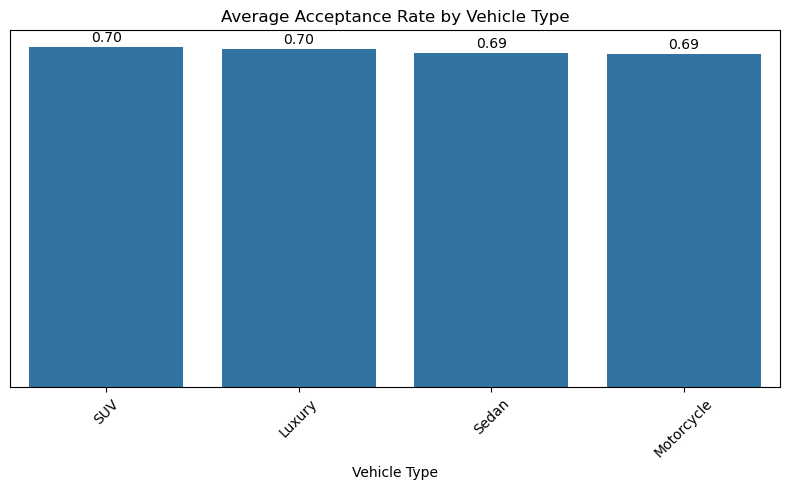

In [34]:
# Calculate mean acceptance rate by vehicle_type and sort descending
mean_acceptance = df_analysis.groupby('vehicle_type')['acceptance_rate'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 5))

# Plot barplot without error bars by setting ci=None, use the sorted order
ax = sns.barplot(x='vehicle_type', y='acceptance_rate', data=mean_acceptance, ci=None, order=mean_acceptance['vehicle_type'])

plt.title("Average Acceptance Rate by Vehicle Type")

plt.xlabel("Vehicle Type")
plt.ylabel("")  # Remove y-axis label

# Hide y-axis ticks and line
ax.yaxis.set_visible(False)

plt.xticks(rotation=45)

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.01, f'{height:.2f}', ha="center")

plt.tight_layout()
plt.show()

## Promotions Table

In [35]:
promotions = table_data['promotions']
promotions.head()

,promo_id,promo_name,promo_type,promo_value,start_date,end_date,target_segment,city_scope,ab_test_groups,test_allocation,success_metric
0,P000,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-25,All,Nairobi,['All'],[1.0],Usage Frequency
1,P001,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-22,All,Cairo,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",Conversion Rate
2,P002,Peak Hour Pass,surge_waiver,1.0,2025-04-26,2025-05-16,All,Cairo,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",ROI
3,P003,Loyalty Bonus,points,100.0,2025-04-26,2025-05-04,Gold+,Nairobi,"['Control', 'Variant A', 'Variant B']","[0.3, 0.4, 0.3]",Conversion Rate
4,P004,Loyalty Bonus,points,100.0,2025-04-26,2025-05-15,Gold+,Nairobi,['All'],[1.0],Usage Frequency


## Inspection and Data Cleaning

In [37]:
promotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   promo_id         20 non-null     object 
 1   promo_name       20 non-null     object 
 2   promo_type       20 non-null     object 
 3   promo_value      20 non-null     float64
 4   start_date       20 non-null     object 
 5   end_date         20 non-null     object 
 6   target_segment   20 non-null     object 
 7   city_scope       20 non-null     object 
 8   ab_test_groups   20 non-null     object 
 9   test_allocation  20 non-null     object 
 10  success_metric   20 non-null     object 
dtypes: float64(1), object(10)
memory usage: 1.8+ KB


In [38]:
# Check unique elements in each column and print them out
for column in promotions.columns:
    unique_values = promotions[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'promo_id':
['P000' 'P001' 'P002' 'P003' 'P004' 'P005' 'P006' 'P007' 'P008' 'P009'
 'P010' 'P011' 'P012' 'P013' 'P014' 'P015' 'P016' 'P017' 'P018' 'P019']

Unique values in 'promo_name':
['Peak Hour Pass' 'Loyalty Bonus' 'First Ride Discount' 'Referral Special']

Unique values in 'promo_type':
['surge_waiver' 'points' 'discount' 'credit']

Unique values in 'promo_value':
[  1.  100.    0.3  15. ]

Unique values in 'start_date':
['2025-04-26']

Unique values in 'end_date':
['2025-05-25' '2025-05-22' '2025-05-16' '2025-05-04' '2025-05-15'
 '2025-05-06' '2025-05-26' '2025-05-03' '2025-05-18' '2025-05-05'
 '2025-05-24' '2025-05-09' '2025-05-19' '2025-05-17' '2025-05-13'
 '2025-05-08']

Unique values in 'target_segment':
['All' 'Gold+' 'New' 'Active']

Unique values in 'city_scope':
['Nairobi' 'Cairo' 'Lagos' 'All-Cities']

Unique values in 'ab_test_groups':
["['All']" "['Control', 'Variant A', 'Variant B']"]

Unique values in 'test_allocation':
['[1.0]' '[0.3, 0.4, 0.3]']


In [40]:
# Convert object columns to 'category' type
category_columns = ['target_segment', 'success_metric','promo_type','promo_name',
                    'city_scope','ab_test_groups']
for col in category_columns:
    promotions[col] = promotions[col].astype('category')

# Convert date columns to datetime
date_columns = ['end_date', 'start_date']
for col in date_columns:
    promotions[col] = pd.to_datetime(promotions[col])

# Check the updated data types
promotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   promo_id         20 non-null     object        
 1   promo_name       20 non-null     category      
 2   promo_type       20 non-null     category      
 3   promo_value      20 non-null     float64       
 4   start_date       20 non-null     datetime64[ns]
 5   end_date         20 non-null     datetime64[ns]
 6   target_segment   20 non-null     category      
 7   city_scope       20 non-null     category      
 8   ab_test_groups   20 non-null     category      
 9   test_allocation  20 non-null     object        
 10  success_metric   20 non-null     category      
dtypes: category(6), datetime64[ns](2), float64(1), object(2)
memory usage: 2.1+ KB


In [42]:
# Checking for duplicates
promotions.duplicated().sum()

0

In [43]:
promotions.describe()

,promo_value,start_date,end_date
count,20.000000,20,20
mean,26.870000,2025-04-26 00:00:00,2025-05-13 08:24:00
min,0.300000,2025-04-26 00:00:00,2025-05-03 00:00:00
25%,0.300000,2025-04-26 00:00:00,2025-05-06 00:00:00
50%,1.000000,2025-04-26 00:00:00,2025-05-14 00:00:00
75%,36.250000,2025-04-26 00:00:00,2025-05-18 06:00:00
max,100.000000,2025-04-26 00:00:00,2025-05-26 00:00:00
std,43.538115,NaN,NaN


## Riders Table

In [ ]:
riders = table_data['riders']
riders.head()

,user_id,signup_date,loyalty_status,age,city,avg_rating_given,churn_prob,referred_by
0,R00000,2025-01-24,Bronze,34.729629,Nairobi,5.0,0.142431,R00001
1,R00001,2024-09-09,Bronze,34.571020,Nairobi,4.7,0.674161,None
2,R00002,2024-09-07,Bronze,47.133960,Lagos,4.2,0.510379,None
3,R00003,2025-03-17,Bronze,41.658628,Nairobi,4.9,0.244779,None
4,R00004,2024-08-20,Silver,40.681709,Lagos,3.9,0.269960,R00002


## Inspection and Data Cleaning

In [45]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  object 
 1   signup_date       10000 non-null  object 
 2   loyalty_status    10000 non-null  object 
 3   age               10000 non-null  float64
 4   city              10000 non-null  object 
 5   avg_rating_given  10000 non-null  float64
 6   churn_prob        10000 non-null  float64
 7   referred_by       3053 non-null   object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


"referred_by" is missing some values

In [46]:
# Percentage of missingness
missing = riders.isnull().mean() * 100
missing = missing [missing > 0]
missing

referred_by    69.47
dtype: float64

In [50]:
#basic description
riders.describe()

,signup_date,age,avg_rating_given,churn_prob
count,10000,10000.000000,10000.000000,10000.000000
mean,2024-04-27 00:28:48,35.154221,4.461510,0.286168
min,2023-04-27 00:00:00,18.000000,2.600000,0.002934
25%,2023-10-27 00:00:00,28.317568,4.200000,0.161691
50%,2024-04-25 00:00:00,35.037671,4.500000,0.266712
75%,2024-10-31 00:00:00,41.691186,4.800000,0.388812
max,2025-04-26 00:00:00,70.000000,5.000000,0.913302
std,NaN,9.545528,0.429162,0.159029


## Summary Analysis Focused on Churn

###  Dataset Overview

The dataset contains **10,000 riders** and focuses on 4 primary variables:

- `signup_date`: When the rider joined the platform
- `age`: Age of the rider
- `avg_rating_given`: Average rating a rider gives after rides
- `churn_prob`: Probability that the rider will churn (leave or become inactive)

---

### 1. Signup Date Distribution

- **Min**: 2023-04-27  
- **Max**: 2025-04-26  
- **Mean**: 2024-04-27  
- **25%–75% Range**: From 2023-10-27 to 2024-10-31  

#### Insights:

- Majority of users signed up **within the last 1.5 years**.
- The data is relatively fresh, with a spread of signup dates across two years.
- The **median signup date** (2024-04-25) is very close to the **mean**, suggesting a relatively symmetrical distribution of signups over time.
- The presence of recent signups implies **new user acquisition is ongoing**.

---

### 2. Age of Riders

- **Min Age**: 18  
- **Max Age**: 70  
- **Mean Age**: 35.15  
- **Standard Deviation**: 9.55  
- **25%–75% (IQR)**: 28.32 to 41.69

####  Insights:

- The **rider base is primarily young to middle-aged adults**.
- The IQR (interquartile range) indicates that **50% of riders are between ages ~28 and ~42**.
- A standard deviation of 9.5 suggests moderate spread—some younger and older riders exist but are not dominant.
- Targeting marketing to the **25–45 age group** may be most effective.

---

###  3. Average Rating Given

- **Min Rating**: 2.6  
- **Max Rating**: 5.0  
- **Mean Rating**: 4.46  
- **Median Rating**: 4.5  
- **Standard Deviation**: 0.43  
- **25%–75% (IQR)**: 4.2 to 4.8

####  Insights:

- Riders generally rate their experiences **very highly** (mean ≈ 4.46 out of 5).
- The tight IQR and low standard deviation suggest a **positively skewed distribution** with minimal low ratings.
- Lower churn may correlate with higher rating behavior (though further correlation analysis is recommended).

---

### 4. Churn Probability

- **Min Churn**: 0.0029 (≈0.3%)  
- **Max Churn**: 0.9133 (≈91%)  
- **Mean Churn**: 0.286  
- **Median Churn**: 0.267  
- **Standard Deviation**: 0.159  
- **25%–75% (IQR)**: 0.1617 to 0.3888

#### Insights:

- The **average rider has ~29% chance of churning**—a considerable risk.
- About **50% of riders fall between 16% and 39% churn risk**, suggesting a moderate-risk population.
- A small group of riders has extremely high churn probabilities (>0.7), representing the **most urgent retention priority**.
- The distribution is **positively skewed**, indicating most users have lower churn risks, but **there is a tail of high-risk users**.

---

### Combined Insights and Business Implications

| Feature            | Insight Summary |
|--------------------|-----------------|
| **Age**            | Riders are mostly 28–42. Younger riders might be more likely to churn, further analysis required. |
| **Signup Date**    | Riders are fairly recent, meaning **early lifecycle engagement is key**. |
| **Rating Given**   | Riders are generous with ratings. Dissatisfied riders (low raters) may need attention. |
| **Churn Probability** | While most are in low-to-medium risk, the **top 25% in churn risk** need **targeted retention efforts**. |

---

### Suggested Next Steps

1. **Churn Segmentation**:
   - Segment riders into **Low**, **Medium**, and **High churn risk** groups using quantiles.
   - Perform behavioral profiling on each group.

2. **RFM Analysis (if transaction data available)**:
   - Include **Recency**, **Frequency**, and **Monetary spend** to better understand user loyalty.

3. **Retention Strategy**:
   - Focus on onboarding experience and engagement of **new users (<90 days)**.
   - Address issues for users with **low ratings given**—they might be silently dissatisfied.

4. **Churn Modeling**:
   - Use `age`, `signup_date`, `rating`, and possibly other behavioral data (if available) to **train a classification model** (e.g., logistic regression, random forest) for predicting churners.

---

### Conclusion

The rider dataset reveals a **young, engaged user base**, with **moderate churn risk**. Most users give high ratings and have joined in the last year, yet **around 30% churn risk on average** signals a need for **proactive retention strategies**, particularly among **long-tenured users and low-rating givers**.


In [47]:
# Check unique elements in each column and print them out
for column in riders.columns:
    unique_values = riders[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'user_id':
['R00000' 'R00001' 'R00002' ... 'R09997' 'R09998' 'R09999']

Unique values in 'signup_date':
['2025-01-24' '2024-09-09' '2024-09-07' '2025-03-17' '2024-08-20'
 '2023-07-10' '2023-08-17' '2023-05-13' '2025-04-02' '2023-07-01'
 '2024-04-30' '2025-04-15' '2023-10-28' '2023-07-02' '2023-09-03'
 '2025-01-15' '2024-05-04' '2023-05-02' '2025-04-19' '2025-02-27'
 '2023-07-19' '2024-08-14' '2025-01-30' '2024-09-15' '2025-04-16'
 '2023-10-24' '2024-08-08' '2023-07-13' '2025-03-15' '2023-12-25'
 '2024-09-05' '2024-03-19' '2024-09-21' '2024-02-21' '2024-06-08'
 '2025-01-25' '2024-03-03' '2023-12-12' '2024-09-04' '2024-07-28'
 '2023-12-18' '2023-10-05' '2024-09-30' '2024-11-24' '2024-12-13'
 '2023-12-15' '2024-04-26' '2024-01-12' '2023-11-28' '2024-05-03'
 '2023-12-29' '2024-01-03' '2024-03-08' '2024-10-04' '2024-01-28'
 '2025-04-04' '2023-10-12' '2025-04-07' '2024-12-14' '2024-07-10'
 '2023-09-24' '2024-07-16' '2024-04-10' '2023-12-26' '2024-07-12'
 '2024-07-23' '2025-0

In [48]:
# Convert object columns to 'category' type
category_columns = ['city', 'loyalty_status']
for col in category_columns:
    riders[col] = riders[col].astype('category')

# Convert date columns to datetime
date_columns = ['signup_date']
for col in date_columns:
    riders[col] = pd.to_datetime(riders[col])

# Check the updated data types
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           10000 non-null  object        
 1   signup_date       10000 non-null  datetime64[ns]
 2   loyalty_status    10000 non-null  category      
 3   age               10000 non-null  float64       
 4   city              10000 non-null  category      
 5   avg_rating_given  10000 non-null  float64       
 6   churn_prob        10000 non-null  float64       
 7   referred_by       3053 non-null   object        
dtypes: category(2), datetime64[ns](1), float64(3), object(2)
memory usage: 488.7+ KB


## Rider: EDA

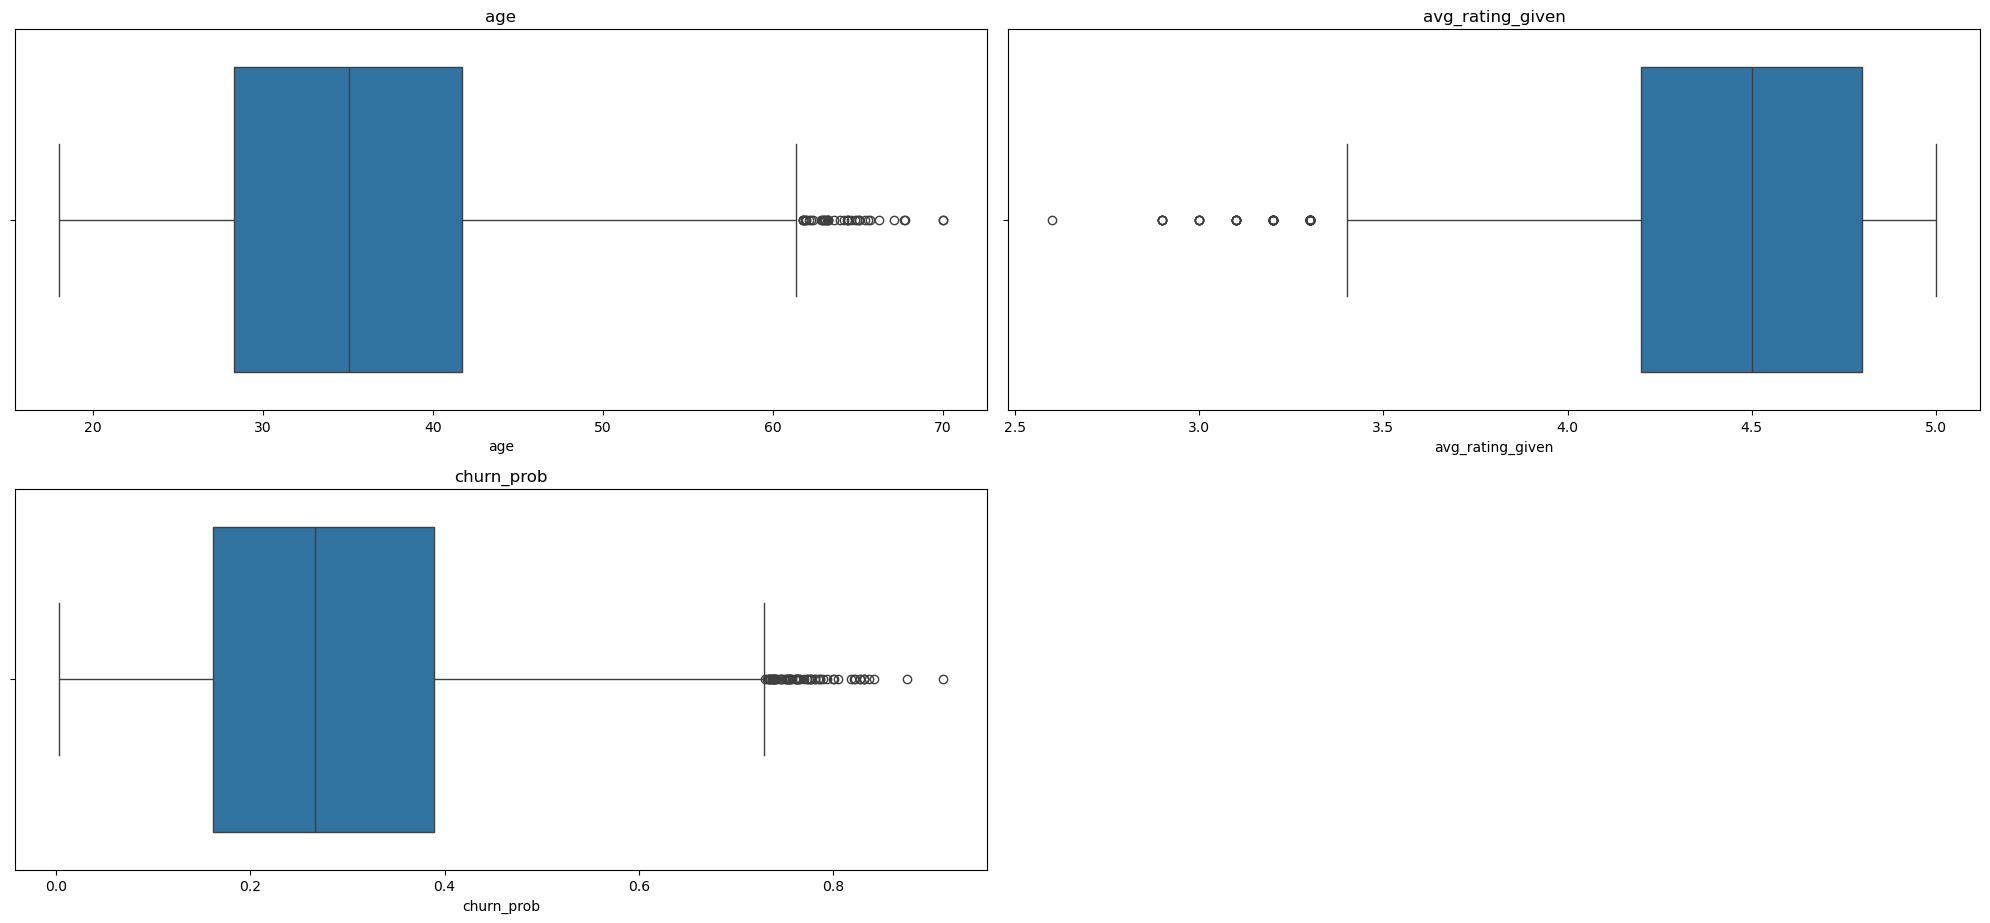

In [52]:
#Get names of all numerical feature
num_vars=riders.select_dtypes(include=['int','float']).columns.tolist()

# Create a figure with subplots

num_cols=len(num_vars)
num_rows = num_cols
fig,axes=plt.subplots(nrows=num_cols,ncols=2,figsize=(20,4.5*num_rows))
axes=axes.flatten()

# Create a countplot for the top 6  values 
for i, var in enumerate(num_vars):
    sns.boxplot(x=riders[var],ax=axes[i])
    axes[i].set_title(var)
    
# Remove any extra empty subplots if needed
if num_cols < len(axes):
    for i in range(num_cols,len(axes)):
        fig.delaxes(axes[i])
        
# Adjust spacing  between subplots
fig.tight_layout()

##  EDA: Age, Average Rating Given, and Churn Probability

This analysis explores the distribution and business implications of key customer-related variables, using summary statistics and box plot insights. These findings are intended to support churn reduction strategies and user experience optimization.

---

### 1. Age Distribution

- The average age is approximately **35 years**.
- Most users fall between the ages of **28 and 42**.
- A few users are above 60 years, appearing as outliers in the distribution.

####  Business Implication:
The core user base consists of **young to middle-aged adults**, likely to be digitally engaged and responsive to interactive features and pricing strategies. 

The older population, although small and statistically treated as outliers, may represent a **valuable niche**. This group may require tailored support such as simplified navigation or personalized assistance.

####  Strategic Actions:
- Segment users into age bands (e.g., <30, 30–45, >60) for targeted user experience design.
- Conduct A/B tests to determine age-specific preferences or friction points.
- Deploy personalized outreach strategies to address potential concerns among older users.

---

### 2. Average Rating Given

- Ratings are tightly clustered around a **median of 4.5**, with the interquartile range between **4.2 and 4.8**.
- A minority of users have given **ratings below 3.4**, identified as outliers.

####  Business Implication:
Overall satisfaction appears to be high. However, the users assigning low average ratings may be early indicators of dissatisfaction, possibly due to unmet expectations, feature gaps, or service issues.

These users are likely at a **higher risk of churn**, despite representing a small fraction of the population.

####  Strategic Actions:
- Monitor users consistently giving low ratings.
- Initiate feedback collection or retention workflows targeted at this segment.
- Investigate the specific features or services associated with low satisfaction to guide product improvements.

---

### 3. Churn Probability

- The **median churn probability** is **0.26**, with most users having a moderate churn likelihood.
- A concentrated group of users shows churn probabilities above **0.7**, considered high-risk outliers.
- A subset of users displays churn probabilities below **0.1**, indicating strong retention.

####  Business Implication:
Churn likelihood is concentrated in a predictable range, with a **critical minority at high risk**. These users are likely exhibiting warning signals such as reduced usage or negative sentiment.

Conversely, users with very low churn probabilities are ideal candidates for **loyalty or referral programs**, contributing positively to business growth.

####  Strategic Actions:
- Segment users by churn probability:
  - **High Risk (≥ 0.7):** Initiate re-engagement campaigns, discounts, or personalized offers.
  - **Moderate Risk (0.3–0.7):** Reinforce engagement through nudges, in-app reminders, or proactive service.
  - **Low Risk (< 0.3):** Introduce loyalty incentives, referral bonuses, or upsell opportunities.
- Align customer support priorities with churn risk levels for proactive intervention.

---

##  Summary Table: Insights and Recommendations

| Variable           | Key Insight                                         | Strategic Recommendation                                 |
|--------------------|-----------------------------------------------------|-----------------------------------------------------------|
| Age                | Core users are between 28–42 years                  | Age-targeted design, messaging, and segmentation           |
| Avg. Rating Given  | High satisfaction with a small dissatisfied group  | Target low raters for retention and feature refinement     |
| Churn Probability  | Minority group shows high churn risk               | Segment by risk and implement tailored retention actions   |



### Does Age Influence Churn Probability?

In [ ]:
from scipy.stats import pearsonr

def analyze_age_churn_relationship(df, age_col='age', churn_col='churn_prob', alpha=0.05):
    """
    Perform a hypothesis test to determine whether age significantly influences churn probability.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - age_col: column name representing age
    - churn_col: column name representing churn probability
    - alpha: significance level (default = 0.05)
    
    Outputs:
    - Statistical inference
    - Business implications
    """
    print("##  Hypothesis Test: Does Age Influence Churn Probability?\n")
    
    # Step 1: Perform Pearson correlation
    corr, p_val = pearsonr(df[age_col], df[churn_col])
    
    # Step 2: State the hypotheses
    print("Hypotheses")
    print(f"- H₀ (Null): There is no linear relationship between {age_col} and {churn_col}. (ρ = 0)")
    print(f"- H₁ (Alt): There is a linear relationship between {age_col} and {churn_col}. (ρ ≠ 0)\n")
    
    # Step 3: Report results
    print("Test Results")
    print(f"- Pearson Correlation Coefficient: {corr:.4f}")
    print(f"- P-value: {p_val:.4e}")
    
    # Step 4: Statistical Decision
    if p_val < alpha:
        print(f"\nReject the null hypothesis at α = {alpha}.")
        print("There is a statistically significant relationship between age and churn probability.\n")
    else:
        print(f"\n Fail to reject the null hypothesis at α = {alpha}.")
        print("No statistically significant relationship was found between age and churn probability.\n")
    
    # Step 5: Business Implications
    print("Business Implications")
    
    if p_val < alpha:
        if corr < 0:
            print("- Older users are slightly less likely to churn compared to younger users.")
            print("- Churn management strategies should pay more attention to younger users.")
        elif corr > 0:
            print("- Older users are slightly more likely to churn than younger ones.")
            print("- Retention strategies should be developed specifically for older riders.")
        else:
            print("- Although statistically significant, the correlation is nearly zero, suggesting minimal practical effect.")
    else:
        print("- Age does not significantly impact churn behavior.")
        print("- Retention strategies may be better informed by other variables like user activity, ride frequency, or service feedback.")   


In [58]:
analyze_age_churn_relationship(riders)

##  Hypothesis Test: Does Age Influence Churn Probability?

### Hypotheses
- H₀ (Null): There is no linear relationship between age and churn_prob. (ρ = 0)
- H₁ (Alt): There is a linear relationship between age and churn_prob. (ρ ≠ 0)

###  Test Results
- Pearson Correlation Coefficient: -0.0028
- P-value: 7.7636e-01

 Fail to reject the null hypothesis at α = 0.05.
No statistically significant relationship was found between age and churn probability.

### Business Implications
- Age does not significantly impact churn behavior.
- Retention strategies may be better informed by other variables like user activity, ride frequency, or service feedback.


In [59]:
# Group age
def assign_age_group(age):
    if age < 30:
        return 'Young'
    elif 30 <= age < 50:
        return 'Middle-aged'
    else:
        return 'Older'
    
riders['age_group'] = riders['age'].apply(assign_age_group)

C:\Users\GIDI\AppData\Local\Temp\ipykernel_4252\2894328251.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


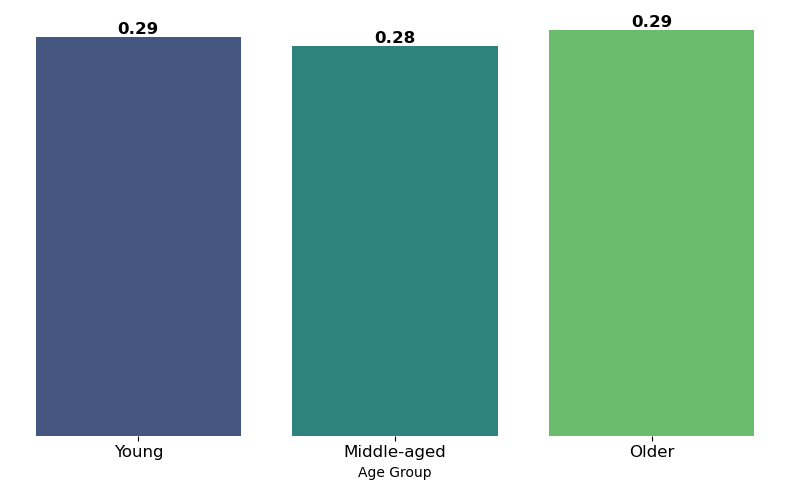

In [ ]:
#Average Churn Probability per Age Group
churn_by_age_group = riders.groupby('age_group')['churn_prob'].mean().reset_index()

# Ensure age group order
age_order = ['Young', 'Middle-aged', 'Older']
churn_by_age_group['age_group'] = pd.Categorical(churn_by_age_group['age_group'], categories=age_order, ordered=True)

churn_by_age_group = churn_by_age_group.sort_values('churn_prob', ascending=False)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=churn_by_age_group,
    x='age_group',
    y='churn_prob',
    palette='viridis'
)

# 🔢 Add data labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')


ax.set_title("")
ax.set_ylabel("")
ax.set_yticks([])
ax.set_xlabel("Age Group")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### Does User Rating Influence Churn Probability?

In [ ]:
def analyze_rating_churn_relationship(df, rating_col='avg_rating_given', churn_col='churn_prob', alpha=0.05):
    """
    Perform a hypothesis test to determine whether the average rating given significantly influences churn probability.

    Parameters:
    - df: pandas DataFrame containing the data
    - rating_col: column name representing user rating
    - churn_col: column name representing churn probability
    - alpha: significance level (default = 0.05)

    Outputs:
    - Statistical inference
    - Business implications
    """
    print("Hypothesis Test: Does User Rating Influence Churn Probability?\n")

    # Step 1: Perform Pearson correlation
    corr, p_val = pearsonr(df[rating_col], df[churn_col])

    # Step 2: State the hypotheses
    print("Hypotheses")
    print(f"- H₀ (Null): There is no linear relationship between {rating_col} and {churn_col}. (ρ = 0)")
    print(f"- H₁ (Alt): There is a linear relationship between {rating_col} and {churn_col}. (ρ ≠ 0)\n")

    # Step 3: Report results
    print("### Test Results")
    print(f"- Pearson Correlation Coefficient: {corr:.4f}")
    print(f"- P-value: {p_val:.4e}")

    # Step 4: Statistical Decision
    if p_val < alpha:
        print(f"\nReject the null hypothesis at α = {alpha}.")
        print("There is a statistically significant relationship between rating and churn probability.\n")
    else:
        print(f"\nFail to reject the null hypothesis at α = {alpha}.")
        print("No statistically significant relationship was found between rating and churn probability.\n")

    # Step 5: Business Implications
    print("Business Implications")

    if p_val < alpha:
        if corr < 0:
            print("- Users who give higher ratings are slightly less likely to churn.")
            print("- High raters may be more satisfied; reinforcing experiences that lead to high ratings could help retain users.")
        elif corr > 0:
            print("- Surprisingly, users who give higher ratings may be slightly more likely to churn.")
            print("- This could suggest a mismatch between user expectations and actual experience over time.")
        else:
            print("- Although statistically significant, the correlation is close to zero, indicating minimal practical influence.")
    else:
        print("- User rating does not significantly impact churn behavior.")
        print("- Retention efforts should focus on more predictive behavioral or demographic variables.")


In [65]:
analyze_rating_churn_relationship(riders)

## Hypothesis Test: Does User Rating Influence Churn Probability?

### Hypotheses
- H₀ (Null): There is no linear relationship between avg_rating_given and churn_prob. (ρ = 0)
- H₁ (Alt): There is a linear relationship between avg_rating_given and churn_prob. (ρ ≠ 0)

### Test Results
- Pearson Correlation Coefficient: -0.0010
- P-value: 9.2051e-01

Fail to reject the null hypothesis at α = 0.05.
No statistically significant relationship was found between rating and churn probability.

### Business Implications
- User rating does not significantly impact churn behavior.
- Retention efforts should focus on more predictive behavioral or demographic variables.


### Do Referred Riders Churn Differently?

In [ ]:
riders['referred_by'] = riders['referred_by'].replace('None', np.nan)
ref_counts = riders['referred_by'].value_counts()
riders['is_referred'] = riders['referred_by'].notnull()
riders['is_referred'] = riders['is_referred'].astype(int)

Text(0.5, 1.0, 'Referred vs Non-Referred Riders')

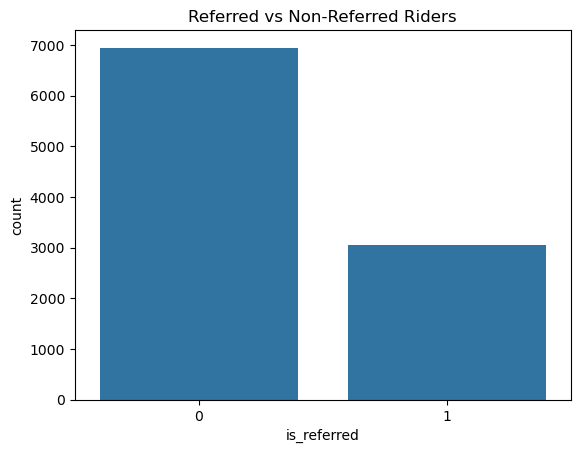

In [69]:
sns.countplot(data=riders, x='is_referred')
plt.title("Referred vs Non-Referred Riders")


In [72]:
from scipy.stats import ttest_ind

def analyze_referral_impact_on_churn(df, referral_col='is_referred', churn_col='churn_prob', alpha=0.05):
    """
    Test whether referred riders behave differently in terms of churn probability.
    
    Parameters:
    - df: pandas DataFrame containing rider data
    - referral_col: binary column indicating whether rider was referred
    - churn_col: churn probability column
    - alpha: significance level (default = 0.05)
    
    Outputs:
    - Statistical test summary
    - Business implications
    """
    print("Hypothesis Test: Do Referred Riders Churn Differently?\n")

    # Split groups
    referred = df[df[referral_col] == 1][churn_col]
    non_referred = df[df[referral_col] == 0][churn_col]

    # the hypotheses
    print("Hypotheses")
    print("- H₀ (Null): Referred and non-referred riders have the same churn probability.")
    print("- H₁ (Alt): Referred riders have a different churn probability than non-referred riders.\n")

    # Descriptive statistics
    print("Group Means")
    print(f"- Average churn probability (Referred): {referred.mean():.4f}")
    print(f"- Average churn probability (Non-referred): {non_referred.mean():.4f}\n")

    # independent t-test
    t_stat, p_val = ttest_ind(referred, non_referred, equal_var=False)  # Welch's t-test
    
    print("Test Results")
    print(f"- T-statistic: {t_stat:.4f}")
    print(f"- P-value: {p_val:.4e}")

    # Conclusion
    if p_val < alpha:
        print(f"\nReject the null hypothesis at α = {alpha}.")
        print("There is a statistically significant difference in churn between referred and non-referred riders.\n")
    else:
        print(f"\nFail to reject the null hypothesis at α = {alpha}.")
        print("No statistically significant difference in churn was found between referred and non-referred riders.\n")

    #Business Implications
    print("Business Implications")
    if p_val < alpha:
        if referred.mean() < non_referred.mean():
            print("- Referred riders churn **less** on average.")
            print("- Referral programs could be a valuable strategy for acquiring more loyal riders.")
        else:
            print("- Referred riders churn **more** on average.")
            print("- The quality of referrals should be reviewed, or the incentives aligned with long-term engagement.")
    else:
        print("- Referral status does not meaningfully impact rider retention.")
        print("- Investment in referral campaigns should be justified by other benefits like cost-per-acquisition or market reach.")


In [73]:
analyze_referral_impact_on_churn(riders, referral_col='is_referred')

Hypothesis Test: Do Referred Riders Churn Differently?

Hypotheses
- H₀ (Null): Referred and non-referred riders have the same churn probability.
- H₁ (Alt): Referred riders have a different churn probability than non-referred riders.

Group Means
- Average churn probability (Referred): 0.2869
- Average churn probability (Non-referred): 0.2859

Test Results
- T-statistic: 0.2934
- P-value: 7.6922e-01

Fail to reject the null hypothesis at α = 0.05.
No statistically significant difference in churn was found between referred and non-referred riders.

Business Implications
- Referral status does not meaningfully impact rider retention.
- Investment in referral campaigns should be justified by other benefits like cost-per-acquisition or market reach.


### Rider Recency, Tenure, and Loyalty

In [ ]:
today = datetime.today()
riders['days_since_signup'] = (today - riders['signup_date']).dt.days

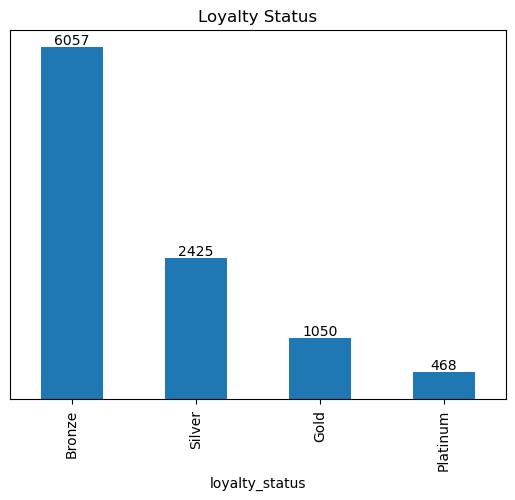

In [79]:
# Calculate value counts and sort them
loyalty_counts = riders['loyalty_status'].value_counts().sort_values(ascending=False)
ax = loyalty_counts.plot(kind='bar', title='Loyalty Status')

# Remove y-axis
ax.yaxis.set_visible(False)

for container in ax.containers:
    ax.bar_label(container)


plt.show()

### Loyalty Status Analysis

####  Loyalty Tier Distribution

| Tier       | Riders | Share of Total |
|------------|--------|----------------|
| **Bronze** | 6,057  | 60%            |
| **Silver** | 2,425  | 24%            |
| **Gold**   | 1,050  | 11%            |
| **Platinum** | 468 | 5%             |

---

####  Key Insights

- **Bronze Dominance**: ~60% of users are Bronze, indicating a large volume of entry-level or low-engagement riders.
- **Mid-tier Drop-off**: Only 24% move up to Silver, and even fewer reach Gold (11%) or Platinum (5%).
- **Top-tier Scarcity**: High-value riders (Platinum) are a minority, suggesting potential underutilization of loyalty incentives.

---

####  Strategic Questions

| Loyalty Funnel      | Key Questions                                       |
|---------------------|-----------------------------------------------------|
| Bronze → Silver     | Are rewards clearly communicated and attainable?    |
| Silver → Gold       | Is the perceived value worth the effort to upgrade? |
| Gold → Platinum     | Are exclusive perks meaningful and visible enough?  |

---

####  Business Recommendations

| Focus Area             | Action Items                                                                 | Expected Impact                                               |
|------------------------|------------------------------------------------------------------------------|---------------------------------------------------------------|
| **Onboarding → Silver**| - Launch a “Reach Silver in 30 Days” challenge  <br> - Double point weeks     | Increase early-stage engagement and retention                 |
| **Silver Retention**   | - Show progress meters to Gold  <br> - Offer birthday perks or ride boosts    | Nurture mid-tier users and incentivize upgrades               |
| **Gold & Platinum**    | - Offer VIP services (e.g. airport pickups)  <br> - Beta-test perks with them | Boost retention of top-tier users; foster brand advocacy      |
| **Referral Incentives**| - Referrers earn tier credit  <br> - Referees start at Silver (if referred by top-tier) | Acquire high-LTV users and reward active advocates            |
| **Risk-Based Targeting**| - Overlay churn scores with loyalty tiers <br> - Prioritize Gold/Platinum at risk | Allocate retention resources where ROI is highest             |

---

#### Next Analytical Steps

- **Cohort Analysis**: Track how long riders stay in each tier and what causes drop-off.
- **Tier-wise Churn Analysis**: Confirm if higher tiers correlate with lower churn.
- **Revenue Analysis**: Validate that benefits delivered to upper tiers return profit.

> 📌 Goal: Shift rider base distribution from Bronze-heavy to a healthier mid and top-tier spread, thereby boosting LTV and reducing churn.


In [82]:
from scipy.stats import f_oneway

def anova_loyalty_churn(df, loyalty_col='loyalty_status', churn_col='churn_prob', alpha=0.05):
    """
    Perform one-way ANOVA to test if churn probability differs across loyalty tiers.
    
    Parameters:
    - df: pandas DataFrame
    - loyalty_col: column with loyalty levels
    - churn_col: churn probability column
    - alpha: significance level (default = 0.05)
    """
    print("## ANOVA: Does Loyalty Tier Affect Churn Probability?\n")

    # Step 1: Prepare groups
    groups = df.groupby(loyalty_col)[churn_col].apply(list)

    # Step 2: Perform ANOVA
    f_stat, p_val = f_oneway(*groups)
    
    # Step 3: Hypotheses
    print("Hypotheses")
    print("- H₀ (Null): Mean churn probability is the same across all loyalty tiers.")
    print("- H₁ (Alt): At least one loyalty tier has a different mean churn probability.\n")

    # Step 4: Results
    print("Test Results")
    print(f"- F-statistic: {f_stat:.4f}")
    print(f"- P-value: {p_val:.4e}")
    
    # Step 5: Interpretation
    if p_val < alpha:
        print(f"\nReject the null hypothesis at α = {alpha}.")
        print("There is a significant difference in churn probability across loyalty tiers.\n")
    else:
        print(f"\nFail to reject the null hypothesis at α = {alpha}.")
        print("No significant difference in churn probability across loyalty tiers.\n")
    
    # Step 6: Business Implications
    print("Business Implications")
    if p_val < alpha:
        print("- Some loyalty tiers experience higher or lower churn than others.")
        print("- Dive deeper with post-hoc tests (e.g., Tukey's HSD) to find which tiers differ.")
        print("- Use findings to refine tier-specific retention or rewards strategies.")
    else:
        print("- Loyalty tier alone may not be a strong driver of churn.")
        print("- Consider combining with behavioral variables for stronger segmentation.")
    
    # Optional: Group-wise mean
    print("\nMean Churn Probability by Loyalty Tier:")
    print(df.groupby(loyalty_col)[churn_col].mean().sort_index())


In [83]:
anova_loyalty_churn(riders)

## ANOVA: Does Loyalty Tier Affect Churn Probability?

Hypotheses
- H₀ (Null): Mean churn probability is the same across all loyalty tiers.
- H₁ (Alt): At least one loyalty tier has a different mean churn probability.

Test Results
- F-statistic: 0.1697
- P-value: 9.1686e-01

Fail to reject the null hypothesis at α = 0.05.
No significant difference in churn probability across loyalty tiers.

Business Implications
- Loyalty tier alone may not be a strong driver of churn.
- Consider combining with behavioral variables for stronger segmentation.

Mean Churn Probability by Loyalty Tier:
loyalty_status
Bronze      0.287045
Gold        0.283970
Platinum    0.284865
Silver      0.285182
Name: churn_prob, dtype: float64


### Does tenure (days since signup) relate to churn or loyalty?

In [ ]:
def analyze_tenure_churn_relationship(df, tenure='days_since_signup', churn_col='churn_prob', alpha=0.05):
    """
    Perform a hypothesis test to determine whether user tenure (days since signup) significantly relates to churn probability or loyalty.

    Parameters:
    - df: pandas DataFrame containing the data
    - tenure: column name representing user tenure (e.g., days since signup)
    - churn_col: column name representing churn probability or loyalty indicator
    - alpha: significance level (default = 0.05)

    Outputs:
    - Statistical inference about the relationship between tenure and churn/loyalty
    - Business implications for retention strategies
    """
    print("Hypothesis Test: Does User Tenure Relate to Churn or Loyalty?\n")

    # Step 1: Perform Pearson correlation
    corr, p_val = pearsonr(df[tenure], df[churn_col])

    # Step 2: State the hypotheses
    print("Hypotheses")
    print(f"- H₀ (Null): There is no linear relationship between {tenure} and {churn_col}. (ρ = 0)")
    print(f"- H₁ (Alt): There is a linear relationship between {tenure} and {churn_col}. (ρ ≠ 0)\n")

    # Step 3: Report results
    print("### Test Results")
    print(f"- Pearson Correlation Coefficient: {corr:.4f}")
    print(f"- P-value: {p_val:.4e}")

    # Step 4: Statistical Decision
    if p_val < alpha:
        print(f"\nReject the null hypothesis at α = {alpha}.")
        print("There is a statistically significant relationship between tenure and churn/loyalty.\n")
    else:
        print(f"\nFail to reject the null hypothesis at α = {alpha}.")
        print("No statistically significant relationship was found between tenure and churn/loyalty.\n")

    # Step 5: Business Implications
    print("Business Implications")

    if p_val < alpha:
        if corr < 0:
            print("- Longer-tenured users are less likely to churn, indicating increased loyalty over time.")
            print("- Focus on onboarding and engagement strategies to help users reach this loyal tenure stage.")
        elif corr > 0:
            print("- Unexpectedly, longer tenure associates with higher churn probability.")
            print("- Investigate potential causes such as declining engagement or unmet evolving expectations.")
        else:
            print("- Although statistically significant, the correlation is close to zero, suggesting tenure has limited practical impact.")
    else:
        print("- Tenure does not significantly influence churn or loyalty in this dataset.")
        print("- Retention efforts might be better targeted toward other behavioral or demographic factors.")


In [85]:
analyze_tenure_churn_relationship(riders)

Hypothesis Test: Does User Tenure Relate to Churn or Loyalty?

Hypotheses
- H₀ (Null): There is no linear relationship between days_since_signup and churn_prob. (ρ = 0)
- H₁ (Alt): There is a linear relationship between days_since_signup and churn_prob. (ρ ≠ 0)

### Test Results
- Pearson Correlation Coefficient: 0.0143
- P-value: 1.5163e-01

Fail to reject the null hypothesis at α = 0.05.
No statistically significant relationship was found between tenure and churn/loyalty.

Business Implications
- Tenure does not significantly influence churn or loyalty in this dataset.
- Retention efforts might be better targeted toward other behavioral or demographic factors.


### Clustering and Segementation

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [92]:
features = ["avg_rating_given", "churn_prob", "days_since_signup", "age", "is_referred"]
X = riders[features].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
# PCA (for KMeans + basic visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE (for better non-linear visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

In [95]:
kmeans = KMeans(n_clusters=5, random_state=42)
riders["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)

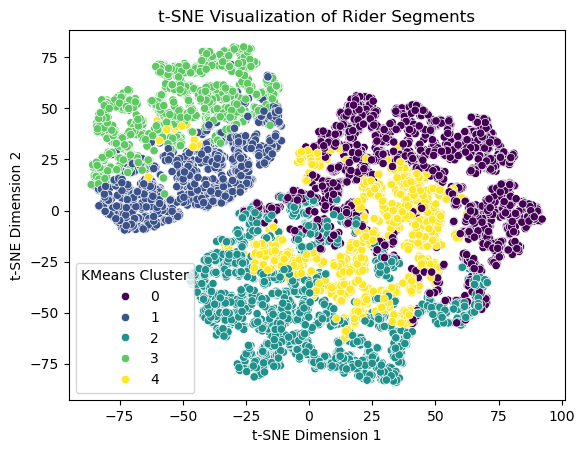

In [96]:
# t-SNE Visualization
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=riders["Cluster_KMeans"], palette="viridis")
plt.title("t-SNE Visualization of Rider Segments")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="KMeans Cluster")
plt.show()


In [98]:
# Analyze the clusters to assign labels based on patterns
segment_summary = riders.groupby("Cluster_KMeans")[features].mean().round(2)
segment_summary["Estimated_Segment"] = [
    "Daily Commuters",
    "Occasional Users",
    "Deal-Seekers",
    "High-Value Loyalists",
    "Inactive / Churn Risks"
]
segment_summary


,avg_rating_given,churn_prob,days_since_signup,age,is_referred,Estimated_Segment
Cluster_KMeans,,,,,,
0,4.47,0.22,582.65,34.57,0.00,Daily Commuters
1,4.43,0.27,200.92,34.88,1.00,Occasional Users
2,4.43,0.21,195.62,35.30,0.00,Deal-Seekers
3,4.48,0.29,565.88,34.92,1.00,High-Value Loyalists
4,4.50,0.50,385.57,36.22,0.03,Inactive / Churn Risks


## Rider Segmentation Analysis Using KMeans and t-SNE

### Objective
To identify actionable customer segments using clustering techniques (K-Means, DBSCAN) on rider behavioral data, followed by visualization with dimensionality reduction (t-SNE, PCA). These segments will help in:

- Personalized marketing strategies
- Churn intervention programs
- Targeted retention campaigns



### Cluster 0 – Daily Commuters
- **Profile:** These riders are loyal, long-term users with consistently high satisfaction and very low churn probability. They rely on the service for regular commuting, likely for work or school.
- **Recommendation:**
  - Introduce subscription plans (monthly passes or priority service).
  - Offer loyalty rewards (e.g ride streak discounts).
  - Consider partnering with employers for corporate ride packages.

---

### Cluster 1 – Occasional Users
- **Profile:** These are relatively new users, likely acquired via referral campaigns. They use the service irregularly and might need incentives to increase ride frequency.
- **Recommendation:**
  - Send targeted nudges like: “Haven’t seen you in a while” with time-limited offers..
  - Offer ride bundles (e.g., “5 rides for 10% off”).
  - Use gamified campaigns (e.g., “Ride 3 times this week, earn a free ride”).

---

### Cluster 2 – Deal-Seekers
- **Profile:** These users are price-sensitive. They’ve been on the platform for a short while but stay loyal as long as there are deals available. They don’t seem to be driven by referral incentives.
- **Recommendation:**
  - Keep them engaged with discounts, coupons, and flash deals.
  - A/B test different promotion types to see which works best.
  - Consider a points-based rewards system for repeat rides.
---

### Cluster 3 – High-Value Loyalists
- **Profile:** Long-term, highly engaged, high-spending users. However, churn probability is a bit high—perhaps due to service issues or lack of continued incentives.
- **Recommendation:**
  - Assign priority support and exclusive features (VIP status).
  - Offer early access to new services (e.g., new ride options or app features).
  - Solicit feedback regularly to increase retention.

---

###  Cluster 4 – Inactive / Churn Risks
- **Profile:** These users are at the highest risk of churn despite giving great ratings. This suggests they may have left for reasons outside service quality—possibly price, relevance, or alternative options.
- **Recommendation:**
  - Launch a "We Miss You" campaign with deep discounts or personalized messages.
  - Conduct a short exit survey to identify drop-off reasons.
  - Use retargeting ads across social platforms or email campaigns.

---

### Summary Table

| Cluster | Segment Name         | Key Insight                             | Recommendation(s)                                    | Expected Impact                            |
|---------|----------------------|------------------------------------------|------------------------------------------------------|---------------------------------------------|
| 0       | Daily Commuters      | Long-tenure, low churn, high satisfaction, non-referred                   | Loyalty rewards, subscription plans, employer tie-ups       | Recurring revenue, higher LTV               |
| 1       | Occasional Users     | Newer users from referrals, moderate churn, infrequent use                 | Gamified nudges, ride bundles, frequency-based offers                | Increase in ride frequency, stronger user habit formation        |
| 2       | Deal-Seekers         | Newish users, highly loyal if given offers, low churn               | Flash Coupons, flash deals, price-based retention schemes                       | Increased usage at low CAC, retention through value promotions                   |
| 3       | High-Value Loyalists | Long-term users, high spend, slightly rising churn risk  | Exclusive perks, Exclusive perks, feedback loops, early access programs   | Reduced churn, higher user satisfaction, advocacy          |
| 4       | Churn Risks          | High churn despite best ratings, older users           | Win-back emails, Win-back campaigns, churn surveys, retargeting          | Re-engagement of lapsed users, insights into churn triggers         |

---

## Sessions Table

In [87]:
sessions = table_data['sessions']
sessions.head()

,session_id,rider_id,session_time,time_on_app,pages_visited,converted,city,loyalty_status
0,S000000,R08605,2025-04-27 18:57:06+02:05,79,4,1,Cairo,Bronze
1,S000001,R08823,2025-04-27 07:32:22+02:27,101,3,0,Nairobi,Silver
2,S000002,R05342,2025-04-27 23:17:25+02:05,12,1,0,Cairo,Bronze
3,S000003,R05057,2025-04-27 14:40:25+00:14,19,1,0,Lagos,Silver
4,S000004,R09614,2025-04-27 08:31:22+00:14,4,1,0,Lagos,Bronze


## Inspection and Data Cleaning

In [99]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   session_id      50000 non-null  object
 1   rider_id        50000 non-null  object
 2   session_time    50000 non-null  object
 3   time_on_app     50000 non-null  int64 
 4   pages_visited   50000 non-null  int64 
 5   converted       50000 non-null  int64 
 6   city            50000 non-null  object
 7   loyalty_status  50000 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.1+ MB


In [100]:
#basic description
sessions.describe()

,time_on_app,pages_visited,converted
count,50000.000000,50000.000000,50000.000000
mean,97.940880,2.766360,0.156280
std,211.675749,1.554137,0.363124
min,0.000000,1.000000,0.000000
25%,12.000000,1.000000,0.000000
50%,35.000000,2.000000,0.000000
75%,90.000000,4.000000,0.000000
max,1800.000000,5.000000,1.000000




### Overview

- **Time on App**:  
  The **average time spent** on the app is approximately **98 minutes**, with a **standard deviation of ~212 minutes**, indicating **significant variability** in user engagement.

- **Pages Visited**:  
  Users **visit an average of 2.77 pages** per session. This suggests that while some users explore deeply, others may **bounce early** or struggle to navigate.

- **Conversion Rate**:  
  The overall **conversion rate is 15.6%**, implying a **large portion of users are not completing desired actions** (e.g., bookings). This connects directly with RideWise’s **churn and promotion challenges**.

---

### Key Insights

- **High Variability in Engagement**:  
  The wide **standard deviation in both time on app and pages visited** implies the presence of **distinct user segments**—some highly engaged, others disengaged. This could be due to **UX issues** or a **lack of personalization**.

- **Low Conversion Rate**:  
  With only **15.6%** of users converting, there is a **strong opportunity** to enhance the user journey and **optimize the conversion funnel**.

- **Churn Indicators**:  
  The data suggests a **potential correlation between time spent and conversion**. Users who spend more time may be **more likely to convert**, but the app might **not be retaining their attention effectively**.

---

### Recommendations

#### 1. Improve User Engagement

- **Personalized Content**:  
  Implement algorithms that **customize the user experience** based on behavior and preferences.  
  E.g., recommend rides based on past activity, or offer dynamic, relevant promotions.

- **Gamification**:  
  Encourage exploration via **rewards, badges, or streaks** for visiting multiple pages or completing actions like booking a ride, adding a payment method, etc.

---

#### 2. Optimize Conversion Strategies

- **Targeted Promotions**:  
  Shift from targeting **inactive users** to **engaged but non-converting users**  
  (e.g., those with `time_on_app > 35 mins` and `pages_visited > 2`).  
  Use **A/B testing** to measure impact and **refine promotion strategies**.

- **Streamlined UX**:  
  Map the **user journey** from app open → booking.  
  Identify **friction points** and **reduce steps** or confusion to create a **seamless conversion path**.

---

### Summary Statistics Table

| Metric           | Mean   | Median | Std Dev | Min | 25% | 50% | 75% | Max  |
|------------------|--------|--------|---------|-----|-----|-----|-----|------|
| **Time on App**  | 97.94  | 35.00  | 211.68  | 0.0 | 12  | 35  | 90  | 1800 |
| **Pages Visited**| 2.77   | 2.00   | 1.55    | 1.0 | 1   | 2   | 4   | 5    |
| **Converted**    | 0.156  | 0.00   | 0.363   | 0.0 | 0   | 0   | 0   | 1    |

---

### Next Steps

- Build a **user segmentation model** using engagement features.
- Design a **churn prediction model** (AUC > 0.85 goal).
- Create **personalized promotion pipelines** with ML-based targeting.
- Run **A/B experiments** on revised onboarding and promotion flow.


In [101]:
# Check unique elements in each column and print them out
for column in sessions.columns:
    unique_values = sessions[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'session_id':
['S000000' 'S000001' 'S000002' ... 'S049997' 'S049998' 'S049999']

Unique values in 'rider_id':
['R08605' 'R08823' 'R05342' ... 'R01431' 'R00358' 'R06087']

Unique values in 'session_time':
['2025-04-27 18:57:06+02:05' '2025-04-27 07:32:22+02:27'
 '2025-04-27 23:17:25+02:05' ... '2025-04-27 14:02:26+02:27'
 '2025-04-27 03:45:34+00:14' '2025-04-27 17:18:42+02:27']

Unique values in 'time_on_app':
[  79  101   12 ... 1412  543  583]

Unique values in 'pages_visited':
[4 3 1 2 5]

Unique values in 'converted':
[1 0]

Unique values in 'city':
['Cairo' 'Nairobi' 'Lagos']

Unique values in 'loyalty_status':
['Bronze' 'Silver' 'Gold' 'Platinum']



In [102]:
# Convert object columns to 'category' type
category_columns = ['city', 'loyalty_status','converted']
for col in category_columns:
    sessions[col] = sessions[col].astype('category')

# Convert date columns to datetime
date_columns = ['session_time']
for col in date_columns:
    sessions[col] = pd.to_datetime(sessions[col])

# Check the updated data types
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   session_id      50000 non-null  object  
 1   rider_id        50000 non-null  object  
 2   session_time    50000 non-null  object  
 3   time_on_app     50000 non-null  int64   
 4   pages_visited   50000 non-null  int64   
 5   converted       50000 non-null  category
 6   city            50000 non-null  category
 7   loyalty_status  50000 non-null  category
dtypes: category(3), int64(2), object(3)
memory usage: 2.1+ MB


## Sessions :EDA

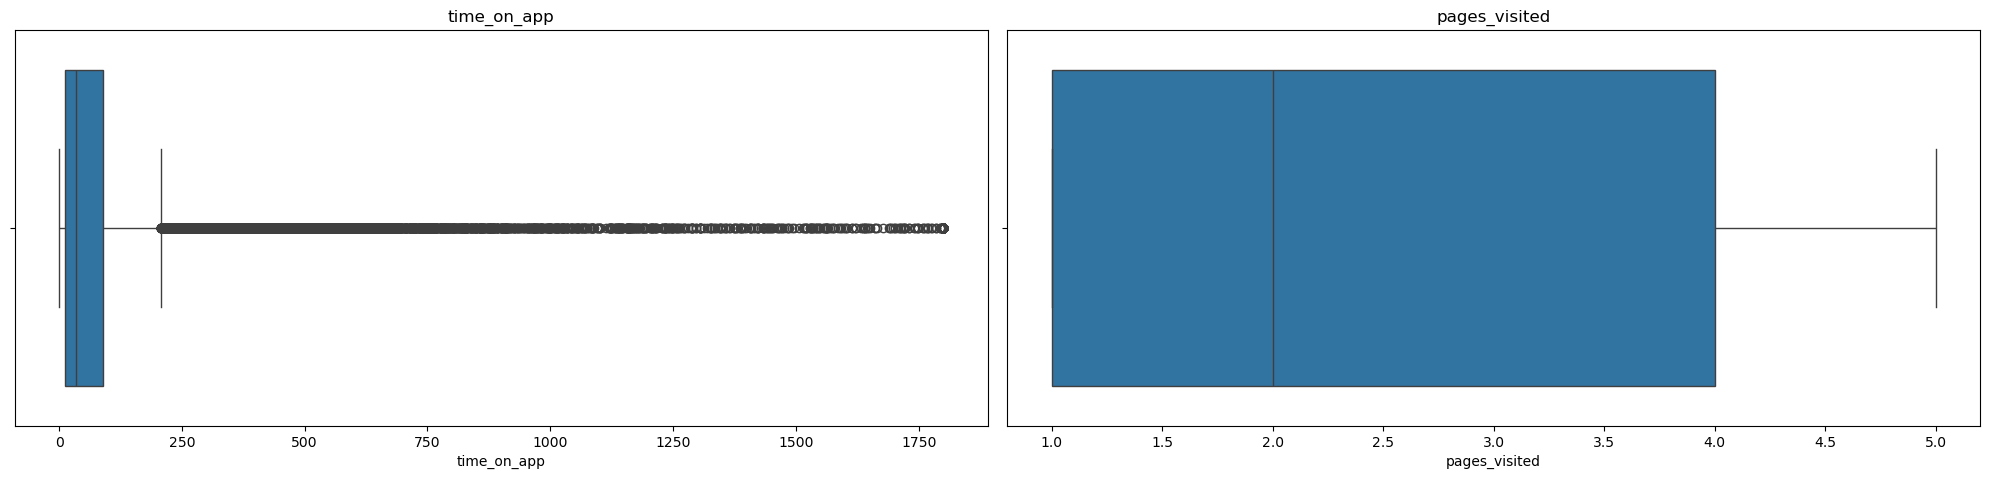

In [103]:
#Get names of all numerical feature
num_vars=sessions.select_dtypes(include=['int','float']).columns.tolist()

# Create a figure with subplots

num_cols=len(num_vars)
num_rows = num_cols
fig,axes=plt.subplots(nrows=num_cols,ncols=2,figsize=(20,4.5*num_rows))
axes=axes.flatten()

# Create a countplot for the top 6  values 
for i, var in enumerate(num_vars):
    sns.boxplot(x=sessions[var],ax=axes[i])
    axes[i].set_title(var)
    
# Remove any extra empty subplots if needed
if num_cols < len(axes):
    for i in range(num_cols,len(axes)):
        fig.delaxes(axes[i])
        
# Adjust spacing  between subplots
fig.tight_layout()

### Clustering Analysis

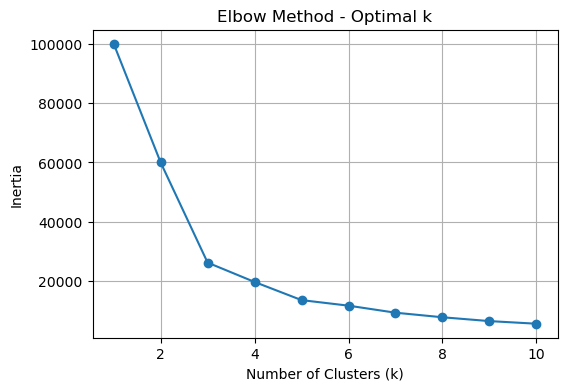

In [104]:

# Use the correct DataFrame
# sessions = pd.read_csv('your_data.csv')  # Uncomment if loading from a file

# Select relevant features for clustering
X = sessions[['time_on_app', 'pages_visited']].copy()

# 💡 Optional: Cap extreme outliers in time_on_app to reduce skew
X['time_on_app'] = X['time_on_app'].clip(upper=X['time_on_app'].quantile(0.99))

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔍 Elbow Method to determine optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 📈 Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Optimal k')
plt.grid(True)
plt.show()




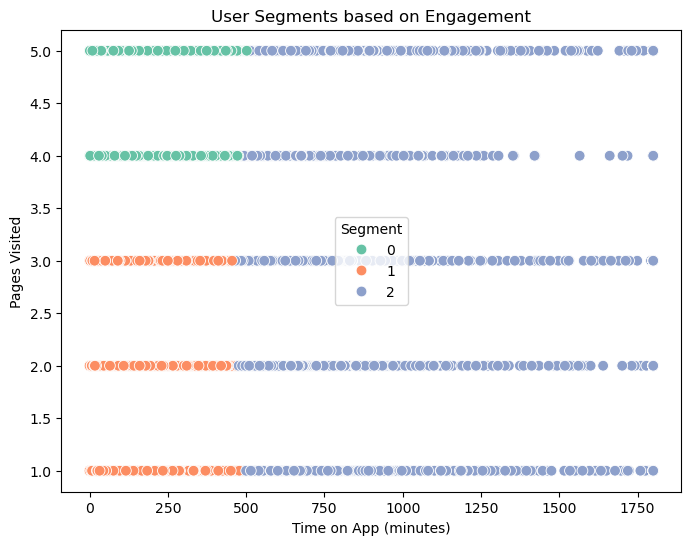

time_on_app               pages_visited              
               mean median  count          mean median  count
segment                                                      
0             64.38   32.0  16472          4.70    5.0  16472
1             64.29   32.0  31729          1.77    2.0  31729
2            998.63  819.0   1799          2.74    2.0   1799

In [105]:
# optimal number of clusters
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
sessions['segment'] = kmeans.fit_predict(X_scaled)

# Visualize the Segments
plt.figure(figsize=(8, 6))
sns.scatterplot(data=sessions, x='time_on_app', y='pages_visited', hue='segment', palette='Set2', s=60)
plt.title('User Segments based on Engagement')
plt.xlabel('Time on App (minutes)')
plt.ylabel('Pages Visited')
plt.legend(title='Segment')
plt.show()

# Summary Statistics for Each Segment
summary = sessions.groupby('segment')[['time_on_app', 'pages_visited']].agg(['mean', 'median', 'count']).round(2)
summary

### Segmentation Analysis – RideWise App Users

#### Summary Table

| Segment | Count  | Time on App (Mean) | Time on App (Median) | Pages Visited (Mean) | Pages Visited (Median) |
|---------|--------|--------------------|-----------------------|----------------------|--------------------------|
| 0       | 16,472 | 64.38 mins         | 32.0 mins             | 4.70                 | 5.0                      |
| 1       | 31,729 | 64.29 mins         | 32.0 mins             | 1.77                 | 2.0                      |
| 2       | 1,799  | 998.63 mins        | 819.0 mins            | 2.74                 | 2.0                      |

---

#### Segment 0 – **Engaged Navigators**
- **Behavior**: Moderate time on app, high number of pages visited.
- **Insight**: These users actively explore the app but may not spend long per session.
- **Challenge**: High browsing doesn't always translate into conversions.

#### Segment 1 – **Passive Users**
- **Behavior**: Low time and low number of pages visited. Largest group.
- **Insight**: Minimal engagement suggests possible confusion or lack of interest.
- **Challenge**: High risk of churn. Current experience may not be compelling enough.

#### Segment 2 – **Deep Engagers / Power Users**
- **Behavior**: Extremely high session duration, few pages visited.
- **Insight**: Likely using one feature extensively (e.g., tracking, chat, streaming).
- **Challenge**: Long time with low navigation may signal either deep focus or usability issues.

---

### Recommendations

#### Segment 0 – **Convert Browsers into Bookers**
- Add clear CTAs on most visited pages.
- Use personalized offers during high engagement moments.
- A/B test conversion nudges (e.g., “Book in 10 mins to get 10% off”).

---

#### Segment 1 – **Re-engage Passive Users**
- Redesign onboarding with walkthroughs or tooltips.
- Use notifications/emails with tailored ride suggestions or discounts.
- Introduce content-based recommendations based on location or intent.

---

#### Segment 2 – **Leverage Deep Engagement**
- Investigate session flow to identify where time is spent.
- Improve navigation for frequently used features.
- Prompt feedback through in-app surveys or chat to understand needs.
- Explore upselling opportunities (e.g., loyalty programs, premium features).

---

### Strategic Impact
- **Segment 1** is the largest and presents the greatest opportunity for retention improvement.
- **Segment 2** could be your premium or advocate users—invest in understanding them.
- **Segment 0** has conversion potential with minimal UX improvement.



In [7]:
table_data['trips']

,trip_id,user_id,driver_id,fare,surge_multiplier,tip,payment_type,pickup_time,dropoff_time,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,weather,city,loyalty_status
0,T000000,R05207,D00315,12.11,1.0,0.00,Card,2024-11-27 18:41:50+02:27,2024-11-27 19:33:50+02:27,-1.108123,36.912209,-1.068155,36.875377,Foggy,Nairobi,Bronze
1,T000001,R09453,D03717,8.73,1.0,0.02,Card,2024-10-28 23:13:48+00:14,2024-10-28 23:26:48+00:14,6.675266,3.515740,6.641734,3.525620,Sunny,Lagos,Gold
2,T000002,R00567,D02035,19.68,1.0,0.00,Card,2025-02-17 05:36:41+02:27,2025-02-17 05:52:41+02:27,-1.248589,37.010668,-1.273182,37.018586,Cloudy,Nairobi,Bronze
3,T000003,R09573,D02657,16.43,1.0,0.01,Mobile Money,2024-06-18 19:27:14+02:05,2024-06-18 19:32:14+02:05,29.819554,31.188780,29.837689,31.232978,Cloudy,Cairo,Bronze
4,T000004,R03446,D01026,8.70,1.0,1.06,Card,2024-10-05 09:58:16+02:27,2024-10-05 10:28:16+02:27,-1.676479,36.729219,-1.638395,36.694063,Sunny,Nairobi,Gold
